# Technical notebook

# Using Machine Learning and Natural Language Processing to predict stock price movements from article headlines

## Research question

Can we predict the **companies performance on the stockmarket based on the headlines** of the news articles?

## Dataset

For this project I retrieved headlines from WSJ online of 6 companies **between 2010/01/01 and 2019/11/22**, after preprocessing I got **1346 observations**.

For labeling the dataset I used daily stockprices which are available on Yahoo Finance.

The performance was **positive (1)**, if the closed stock price compared to the previous day was 1.5 percent point above the S&P500 average, and the trading volume was above the two weeks rolling average.

The performance was **negative (0)**, if that stock performance was 1.5 percent point lower than the S&P500 average, and the trading volume was above the two weeks rolling average.

## Modeling

The following Machine Learning algorithms was used to make predictions:

- Naive Bayes Model using NLTK library
- Logistic Regression
- K-Nearest Neighbors
- XG Boosting
- Support Vector Machine
- Multinomial Naive Bayes Model
- Bernoulli Naive Bayes Model
- Gaussian Naive Bayes Model



## Importing dataset

In [1]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import pickle
import nltk

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
# create our training data list - this is a list of text of headlines/summaries
train_data = train['tokens']
test_data = test['tokens']

In [4]:
print('Number of train data: ',len(train_data))
print('Number of test data:  ',len(test_data))

Number of train data:  1076
Number of test data:   270


# Vectorizing - Feature creation

This advanced method is the **TF-IDF vectorizer**. This is an acronym that stands for “Term Frequency – Inverse Document Frequency" which are the components of the resulting scores assigned to each word. This vectorizer result an inverse frequency, the most frequent words get the lowest score.

**Term Frequency:** This summarizes how often a given word appears within a document.

**Inverse Document Frequency:** This downscales words that appear a lot across documents.

In math notation, Tf-Idf features are computed as

$tf(t, d) \times idf(t) $,

where t is the term (a word in this case), d is the document (a randomly generated string), and tf is a function which counts the number of occurences of t in d. The idf function is computed as

$\log{\frac{1+n_{d}}{1+df(d, t)}}+1 $,

where $n_{d}$ is the total number of documents and $df(t)$ is the number of documents that contain t.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer="word",
                                   tokenizer=None,
                                   preprocessor=None,
                                   max_features=1500,
                                   ngram_range=(1, 2))

train_data_features = tfidf_vectorizer.fit_transform(train_data).toarray()
test_data_features = tfidf_vectorizer.transform(test_data).toarray()

# check shapes
print('Shape of train_data: ', train_data_features.shape,
      '\nShape of test_data:  ', test_data_features.shape)

Shape of train_data:  (1076, 1500) 
Shape of test_data:   (270, 1500)


In [6]:
vocab_tfidf = tfidf_vectorizer.get_feature_names()
# tfidf_vectorizer.idf_ #inverse document frequency
tfidf_df = pd.DataFrame(tfidf_vectorizer.idf_, index=vocab_tfidf)

In [7]:
#restructure the target variable
y_train = train.label
y_test = test.label

#check the shapes of target variable
print('Shape of train target: ', y_train.shape,
      '\nShape of test target:  ', y_test.shape)

Shape of train target:  (1076,) 
Shape of test target:   (270,)


In [8]:
y_train.value_counts(normalize=True)

0.0    0.504647
1.0    0.495353
Name: label, dtype: float64

In [9]:
y_test.value_counts(normalize=True)

0.0    0.503704
1.0    0.496296
Name: label, dtype: float64

In [10]:
with open('tfidf.sav', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

### Collectiong model result

In [11]:
model_score = {}

## Naive Bayes Classifier using NLTK library

### Restructuring dataset for this specific purpose

In [12]:
#using the previously imported dataset
train_pos = np.array(train.loc[train.label==1].tokens)
train_neg = np.array(train.loc[train.label==0].tokens)
test_pos = np.array(test.loc[test.label==1].tokens)
test_neg = np.array(test.loc[test.label==0].tokens)

#create featureset by using Freqency distribution
all_words = []
for doc in train_pos:
    all_words += doc.split(' ')
for doc in train_neg:
    all_words += doc.split(' ')

all_words = nltk.FreqDist(all_words)
word_features = list(all_words.keys())

def find_features(tokens):
    features = {}
    for w in word_features:
        features[w] = (w in tokens)
    return features

#create train features
documents_train = []
for doc in train_pos:
    documents_train.append((doc, 'pos'))
for doc in train_neg:
    documents_train.append((doc, 'neg'))
train_features = [(find_features(text), category) for text, category in documents_train]

#create test features
documents_test = []
for doc in test_pos:
    documents_test.append((doc, 'pos'))
for doc in test_neg:
    documents_test.append((doc, 'neg'))
test_features = [(find_features(text), category) for text, category in documents_test]

### Model fitting

In [13]:
nb_clf = nltk.NaiveBayesClassifier.train(train_features)

nb_train = nltk.classify.accuracy(nb_clf, train_features)
nb_test = nltk.classify.accuracy(nb_clf, test_features)

#collecting results
model_score['Naive Bayes from NLTK'] = {'train': nb_train, 'test': nb_test}

#printing out the result
print(f'Train accuracy score: {nb_train:.3f}')
print(f'Test accuracy score: {nb_test:.3f}')

Train accuracy score: 0.928
Test accuracy score: 0.567


In [15]:
#save the fitted model
with open('nb_model.sav', 'wb') as file:
    pickle.dump(nb_clf, file)

In [16]:
# load the model from disk
nb_model = pickle.load(open('nb_model.sav', 'rb'))

In [14]:
# most important features and their likelyhood 
nb_clf.show_most_informative_features(50)

Most Informative Features
                  supply = True              pos : neg    =      7.1 : 1.0
                strategy = True              pos : neg    =      5.8 : 1.0
                     lag = True              neg : pos    =      5.6 : 1.0
                   split = True              pos : neg    =      5.1 : 1.0
                question = True              neg : pos    =      4.5 : 1.0
                 private = True              neg : pos    =      4.5 : 1.0
                activity = True              pos : neg    =      4.4 : 1.0
             development = True              pos : neg    =      4.4 : 1.0
             consecutive = True              neg : pos    =      4.3 : 1.0
                    list = True              neg : pos    =      4.3 : 1.0
                     lot = True              neg : pos    =      4.1 : 1.0
                  intend = True              pos : neg    =      3.7 : 1.0
                  secure = True              pos : neg    =      3.7 : 1.0

## Logistic Regression 

In [17]:
from sklearn.linear_model import LogisticRegression

# gridsearch original parameters:
params = [{'C': np.logspace(-2, 4, 7),
           'penalty': ['l1', 'l2'],
           'solver': ['lbfgs']
          }]

# gridsearch best parameters:
params = [{'C': [1], 'penalty': ['l1'], 'solver': ['liblinear'] }]

logreg_grid = GridSearchCV(estimator=LogisticRegression(random_state=111),
                           param_grid=params,
                           scoring='accuracy',
                           refit='accuracy',
                           return_train_score = True,
                           cv=5, verbose=2, n_jobs=-1)

#fit the model
logreg_grid.fit(train_data_features, y_train)

#accuracy scores
logreg_train = logreg_grid.best_estimator_.score(train_data_features, y_train)
logreg_test = logreg_grid.best_estimator_.score(test_data_features, y_test)

#collecting
model_score['Logistic regression'] = {'train': logreg_train, 'test': logreg_test}

#printing out the result
print(f'Best parameters: {logreg_grid.best_params_}')
print(f'Train accuracy score: {logreg_train:.3f}')
print(f'Test accuracy score:  {logreg_test:.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Train accuracy score: 0.623
Test accuracy score:  0.544


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


In [ ]:
#save the fitted model
with open('logreg_model.sav', 'wb') as file:
    pickle.dump(logreg_grid.best_estimator_, file)

In [ ]:
# load the model from disk
logreg_model = pickle.load(open('logreg_model.sav', 'rb'))

## K Nearest Neighbors

In [18]:
from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors': range(1, 30, 2)}
params = {'n_neighbors': [5]}

knn_grid = GridSearchCV(estimator=KNeighborsClassifier(),
                        param_grid=params,
                        scoring='accuracy',
                        refit='accuracy',
                        return_train_score=True,
                        cv=5, verbose=2, n_jobs=-1)

#fit the model
knn_grid.fit(train_data_features, y_train)

#accuracy scores
knn_train = knn_grid.best_estimator_.score(train_data_features, y_train)
knn_test = knn_grid.best_estimator_.score(test_data_features, y_test)

#collecting results
model_score['KNN'] = {'train': knn_train, 'test': knn_test}

print(f'Best parameters: {knn_grid.best_params_}')
print(f'Train accuracy score: {knn_train:.3f}')
print(f'Test accuracy score:  {knn_test:.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


Best parameters: {'n_neighbors': 5}
Train accuracy score: 0.691
Test accuracy score:  0.556


In [ ]:
#save the fitted model
with open('knn_model.sav', 'wb') as file:
    pickle.dump(knn_grid.best_estimator_, file)

In [ ]:
# load the model from disk
knn_model = pickle.load(open('knn_model.sav', 'rb'))

## XG Boosting

In [19]:
import xgboost as xgb

params = {'learning_rate': [0.1, 0.15],
          'max_depth': [2, 3, 4, 5, 8],
          'min_child_weight': [0.1, 0.2, 0.3],
          'subsample': [0.2, 0.3, 0.5],
          'n_estimators': [10, 50, 100, 150],
          }

params = {'learning_rate': [0.15],
          'max_depth': [3],
          'reg_alpha': [0.5],
          'subsample': [0.25],
          'n_estimators': [150],
          }

xgboost_grid = GridSearchCV(estimator=xgb.XGBClassifier(random_state=111),
                            param_grid=params,
                            scoring='accuracy',
                            refit='accuracy',
                            return_train_score=True,
                            cv=5, verbose=2, n_jobs=-1)

#fit the model
xgboost_grid.fit(train_data_features, y_train)

#accuracy scores
xgboost_train = xgboost_grid.best_estimator_.score(train_data_features, y_train)
xgboost_test = xgboost_grid.best_estimator_.score(test_data_features, y_test)

#collecting results
model_score['Extreme Gradient Boosting'] = {'train': xgboost_train, 'test': xgboost_test}

#printing out the result
print(f'Best parameters: {xgboost_grid.best_params_}')
print(f'Train accuracy score: {xgboost_train:.3f}')
print(f'Test accuracy score: {xgboost_test:.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.8s finished


Best parameters: {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 150, 'reg_alpha': 0.5, 'subsample': 0.25}
Train accuracy score: 0.753
Test accuracy score: 0.515


In [ ]:
#save the fitted model
with open('xgboost_model.sav', 'wb') as file:
    pickle.dump(xgboost_grid.best_estimator_, file)

In [ ]:
#upload the estimator for further use
with open('xgboost_model.sav', 'rb') as file:
    xgboost_model = pickle.load(file)

## Support Vector Machine

In [20]:
from sklearn import svm

params = {'kernel': ['linear', 'poly', 'rbf'],
          'C': [0.1, 1, 10, 1000], #high C allows narrow mistakes
          'degree': [2, 3]}

params = {'kernel': ['linear'], 'C': [1]}

svm_grid = GridSearchCV(estimator=svm.SVC(random_state=111, probability=True),
                        param_grid=params,
                        scoring='accuracy',
                        return_train_score=True,
                        cv=5, verbose=2, n_jobs=-1)

#fit the model
svm_grid.fit(train_data_features, y_train)

#accuracy scores
svm_train = svm_grid.best_estimator_.score(train_data_features, y_train)
svm_test = svm_grid.best_estimator_.score(test_data_features, y_test)

#collecting results
model_score['Support Vector Machine'] = {'train': svm_train, 'test': svm_test}

#printing out the result
print(f'Best parameters: {svm_grid.best_params_}')
print(f'Train accuracy score: {svm_train:.3f}')
print(f'Test accuracy score: {svm_test:.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.4s finished


Best parameters: {'C': 1, 'kernel': 'linear'}
Train accuracy score: 0.873
Test accuracy score: 0.552


In [21]:
#save the fitted model
with open('svm_model.sav', 'wb') as file:
    pickle.dump(svm_grid.best_estimator_, file)

In [22]:
with open('svm_model.sav', 'rb') as file:
    svm_model = pickle.load(file)

In [24]:
feat_imp_svm = pd.DataFrame(svm_grid.best_estimator_.coef_[0], index=vocab_tfidf, 
                            columns=['Coefficient'])
feat_imp_svm['Absolute Coefficient'] = feat_imp_svm.Coefficient.apply(lambda x: abs(x))
feat_imp_svm = feat_imp_svm.sort_values(by='Absolute Coefficient', ascending=False)
feat_imp_svm[:10]

,Coefficient,Absolute Coefficient
fall,-2.163302,2.163302
investment,1.966763,1.966763
battery,1.948199,1.948199
sign,1.903654,1.903654
down,-1.852947,1.852947
year,-1.812611,1.812611
strong,1.713187,1.713187
result,-1.687945,1.687945
chief,-1.623979,1.623979
deal,-1.600528,1.600528


## Multinomial Naive Bayes

posterior = prior * likelyhood / evidence

**posterior:** the probablity that the document is classified as positive (negative), given it contains a word

**prior**: the probability that the document is classified as positive (negative)

**likelyhood:**  probability of the word given the document is classified positive (negative)
 
**evidence:** probability of occurance of the word

In [46]:
from sklearn.naive_bayes import MultinomialNB

params = {'alpha': [1.1]}

mnb_grid = GridSearchCV(estimator=MultinomialNB(),
                        param_grid=params,
                        scoring='accuracy',
                        return_train_score=True,
                        cv=5, verbose=2, n_jobs=-1)

#fit the model
mnb_grid.fit(train_data_features, y_train)

#accuracy scores
mnb_train = mnb_grid.best_estimator_.score(train_data_features, y_train)
mnb_test = mnb_grid.best_estimator_.score(test_data_features, y_test)

#collecting results
model_score['Multinomial Naive Bayes'] = {'train': mnb_train, 'test': mnb_test}

#printing out the result
print(f'Best parameters: {mnb_grid.best_params_}')
print(f'Train accuracy score: {mnb_train:.3f}')
print(f'Test accuracy score: {mnb_test:.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters: {'alpha': 1.1}
Train accuracy score: 0.860
Test accuracy score: 0.596


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


In [26]:
#save the fitted model
with open('mnb_model.sav', 'wb') as file:
    pickle.dump(mnb_grid.best_estimator_, file)

In [27]:
#import the fitted model
with open('mnb_model.sav', 'rb') as file:
    mnb_model = pickle.load(file)

## Bernoulli Naive Bayes

In [28]:
from sklearn.naive_bayes import BernoulliNB

params = {'alpha': [8]}

bnb_grid = GridSearchCV(estimator=BernoulliNB(),
                        param_grid=params,
                        scoring='accuracy',
                        return_train_score=True,
                        cv=5, verbose=2, n_jobs=-1)

#fit the model
bnb_grid.fit(train_data_features, y_train)

#accuracy scores
bnb_train = bnb_grid.best_estimator_.score(train_data_features, y_train)
bnb_test = bnb_grid.best_estimator_.score(test_data_features, y_test)

#collecting results
model_score['Bernoulli Naive Bayes'] = {'train': bnb_train, 'test': bnb_test}

#printing out the result
print(f'Best parameters: {bnb_grid.best_params_}')
print(f'Train accuracy score: {bnb_train:.3f}')
print(f'Test accuracy score: {bnb_test:.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters: {'alpha': 8}
Train accuracy score: 0.814
Test accuracy score: 0.585


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [29]:
#save the fitted model
with open('bnb_model.sav', 'wb') as file:
    pickle.dump(bnb_grid.best_estimator_, file)

In [30]:
with open('bnb_model.sav', 'rb') as file:
    bnb_model = pickle.load(file)

## Gaussian Naive Bayes

In [31]:
from sklearn.naive_bayes import GaussianNB

params = [{'alpha':[6]}]

gnb_grid = GridSearchCV(estimator=BernoulliNB(),
                        param_grid=params,
                        scoring='accuracy',
                        return_train_score=True,
                        cv=5, verbose=2, n_jobs=-1)

#fit the model
gnb_grid.fit(train_data_features, y_train)

#accuracy scores
gnb_train = gnb_grid.best_estimator_.score(train_data_features, y_train)
gnb_test = gnb_grid.best_estimator_.score(test_data_features, y_test)

#collecting results
model_score['Gaussian Naive Bayes'] = {'train': gnb_train, 'test': gnb_test}

#printing out the result
print(f'Best parameters: {gnb_grid.best_params_}')
print(f'Train accuracy score: {gnb_train:.3f}')
print(f'Test accuracy score: {gnb_test:.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters: {'alpha': 6}
Train accuracy score: 0.822
Test accuracy score: 0.585


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [32]:
#save the fitted model
with open('gnb_model.sav', 'wb') as file:
    pickle.dump(gnb_grid.best_estimator_, file)

In [33]:
with open('gnb_model.sav', 'rb') as file:
    gnb_model = pickle.load(file)

## Model selection

In [54]:
results = pd.DataFrame(model_score).T.applymap(lambda x: round(x,3))
results[['train', 'test']]

,train,test
Naive Bayes from NLTK,0.928,0.567
Logistic regression,0.623,0.544
KNN,0.691,0.556
Extreme Gradient Boosting,0.753,0.515
Support Vector Machine,0.873,0.552
Bernoulli Naive Bayes,0.814,0.585
Gaussian Naive Bayes,0.822,0.585
Multinomial Naive Bayes,0.860,0.596


## Confusion matrix

In [35]:
from sklearn.metrics import confusion_matrix
# svm
cnf_matrix = confusion_matrix(y_test, svm_grid.predict(test_data_features))
cnf_matrix

array([[79, 57],
       [64, 70]])

In [36]:
# naiv bayes
cnf_matrix = confusion_matrix(y_test, mnb_grid.predict(test_data_features))
cnf_matrix

array([[91, 45],
       [64, 70]])

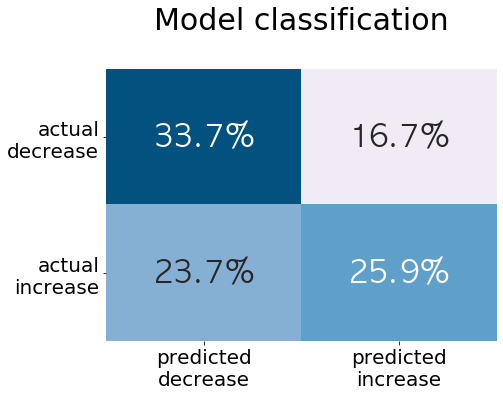

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(y_test, features, model, palname):
    '''
    This function plots a confusion matrix for the specified model and drug.
    Parameters
    ----------
        y_test: DataFrame or series, test set of target values
        features: DataFrame or series, test set of features
        model: model (best estimator) used
        palname: seaborn palette name
    Returns
    -------
    Confusion Matrix showing the percentages for each TP, FP, TN, FN
    '''
#     matrix = confusion_matrix(y_test, model.best_estimator_.predict(features))
    matrix = confusion_matrix(y_test, model.predict(features))
    matrix = matrix / matrix.astype(np.float).sum()
    df_matrix = pd.DataFrame(matrix,
                             columns=['predicted\ndecrease', 'predicted\nincrease'],
                             index=['actual\ndecrease', 'actual\nincrease'])
    plt.figure(figsize=(7, 5))
    col = sns.color_palette(palname, 10)
    sns.heatmap(df_matrix, annot=True,
                fmt='.1%', cmap=col, cbar=False,
                annot_kws={"size": 30, 'weight':'bold', 
                           'fontname':'AppleGothic'})
    plt.title(f'Model classification\n', fontsize=30)
    plt.yticks(rotation=0, fontsize=20)
    plt.xticks(fontsize=20)
    
plot_confusion_matrix(y_test, test_data_features, mnb_grid.best_estimator_, 'PuBu')


## Feature importance based on Naive Bayes Classifier

The feature importance from Naive Bayes model can be written only into the screen, that is why we need here some trick to convert it into a processable format.

In [39]:
from io import StringIO
import sys
from contextlib import redirect_stdout

print_features = StringIO()
with redirect_stdout(print_features):
    nb_clf.show_most_informative_features(200)


In [40]:
# print_features.getvalue() will be a pure text of which we need to get the information

import re

words = re.findall(r'([a-z]+).=', print_features.getvalue())
cat = re.findall(r'([a-z]+).:', print_features.getvalue()) #cat stands for category
likelyhood = re.findall(r'([0-9].[0-9]).:',print_features.getvalue())

important_features = pd.DataFrame([words,cat,likelyhood]).T
important_features.columns = ['word', 'cat', 'likelyhood']
important_features.likelyhood = important_features.likelyhood.astype(float)
important_features.head()

,word,cat,likelyhood
0,supply,pos,7.1
1,strategy,pos,5.8
2,lag,neg,5.6
3,split,pos,5.1
4,question,neg,4.5


In [43]:
neg_words = {row['word']:row['likelyhood'] for i, row in 
             important_features.loc[important_features.cat=='neg'].iterrows()}
pos_words = {row['word']:row['likelyhood'] for i, row in 
             important_features.loc[important_features.cat=='pos'].iterrows()}

In [44]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
stopwords.update(['Mr.', 'Mrs.', 'Ford', 'Tesla', 'Boeing', 'Microsoft', 'Goldman', 'Sachs',
                  'GE','General', 'Electric', 'tack', 'prep'])

def plot_wordcloud(text_freq_dict):
    '''
    Generates wordcloud plot from text frequency distribution
    ---------
    Inputs:
        text_freq_dict: dictionary of text (string) and it's frequency (float)
    ---------
    Output:
        wordcloud plot, but no return value
    '''
    plt.figure(figsize=(8,6))
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap='tab10',
                          max_words=50, width= 400, height=300)
    wordcloud.generate_from_frequencies(text_freq_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#colormaps: 'tab10'

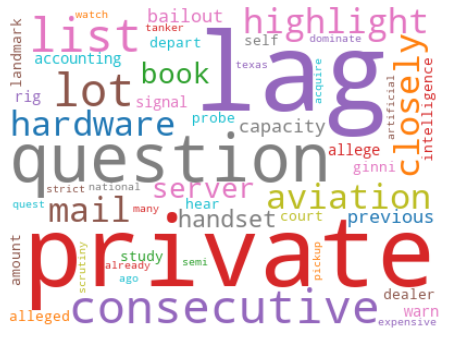

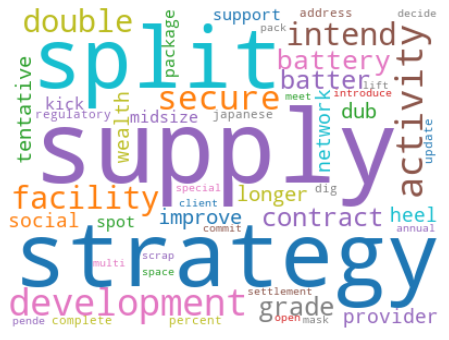

In [266]:
plot_wordcloud(neg_words)
plot_wordcloud(pos_words)